# Model 0.01 - Baseline Random Forest
 - Random Forest chosen as it works fairly well with limited configuration
 - Top 10 keywords picked from descriptions
 - multiple Color and Breeds combined and assigned to flags (one-hot encoding)
 - Categorical features split using pandas dummies (one-hot encoding)
 - Random 20% test data split from training
 - Standard scoring and quadratic weighted kappa applied (0.41 and 0.33 respectively)

In [1]:
import ml_metrics
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/home/rich/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Importing the data

In [236]:
df_train = pd.read_csv("../input/train/train.csv", index_col="PetID")
df_test = pd.read_csv("../input/test/test.csv", index_col="PetID")
df_breeds = pd.read_csv("../input/breed_labels.csv")
df_colors = pd.read_csv("../input/color_labels.csv")

In [3]:
colors = df_colors['ColorID']
breeds = df_breeds['BreedID']

## Functions

In [17]:
def apply_word_flags(df, words):
    """Creates binary columns for words which appear in the description"""
    for word in words:
        df[word] = 0
    for i, desc in df['Description'].items():
        try:
            for word in desc.split():
                word = word.lower()
                if word in words:
                    df.at[i,word] = 1
        except AttributeError:
            continue
    df = df.drop(columns=['Description'])
    return df

In [5]:
keywords = ['home', 'good' , 'adopt', 'loving', 'give', 'looking', 'playful', 'rescued', 'cat', 'contact']

In [6]:
def apply_color_flags(df, colors):
    """Combines Colors 1,2 & 3 into binary columns for each possible colours"""
    for c in colors:
        df[f'C{c}'] = 0
    for i,colors in df[['Color1', 'Color2', 'Color3']].iterrows():
        for c in colors:
            if c != 0:
                df.at[i,f'C{c}'] = 1
    df = df.drop(columns=['Color1', 'Color2', 'Color3'])
    return df

In [7]:
def apply_breed_flags(df, breeds):
    """Combines Breeds 1 & 2 into binary columns for each possible breed"""
    for b in breeds:
        df[f'B{b}'] = 0
    for i,breeds in df[['Breed1', 'Breed2']].iterrows():
        for b in breeds:
            if b != 0:
                df.at[i,f'B{b}'] = 1
    df = df.drop(columns=['Breed1', 'Breed2'])
    return df

## Preparing training data

In [242]:
X_train = apply_word_flags(df_train.copy(), keywords)
X_train = apply_color_flags(X_train, colors)
X_train = apply_breed_flags(X_train, breeds)
X_train = pd.get_dummies(X_train, columns=['Gender', 
                                           'Vaccinated', 'Dewormed', 'Sterilized', 
                                           'State'])
y_train_all = X_train['AdoptionSpeed']
X_train_all = X_train.drop(columns=['Name', 'RescuerID', 'AdoptionSpeed'])

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X_train_all, y_train_all, test_size=0.20).copy()

## Run Random Forest model

In [244]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
prediction = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.41613871290430143

In [245]:
ml_metrics.quadratic_weighted_kappa(rater_a=prediction, rater_b=y_test)

0.3209893556254283

## Analysing the results 

In [22]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [23]:
feature_importances.iloc[:10,:]

,importance
PhotoAmt,0.095719
Age,0.094106
FurLength,0.033224
MaturitySize,0.032352
Quantity,0.031452
C1,0.031222
C7,0.031063
Fee,0.027763
C2,0.026179
home,0.022104


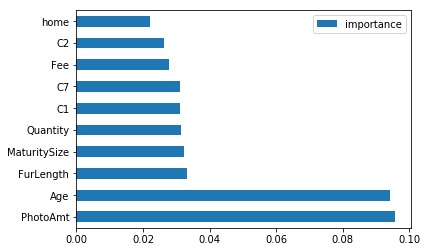

In [24]:
feature_importances.iloc[:10,:].plot.barh()

There is a huge significance in the **number of photos** and **Age**. 

My assumption prior to beginning was the **number of photos** will have high significance, but I was not expecting it to be so high. My thoughts are the features such as fur length and size, for example, will be a reflection of what is shown in the photos.

**Age** is an easy one, because... kittens and puppies! tbc

What's also worth considering is the number of colours which are represented. C1 (black), C7 (white) and C2 (brown) all show in the top ten. 

## Assessing Colours: black, white and brown
It appears pets with the main color white tend to be adopted more quickly, having distinguishably quicker adoption speeds (see graph below). This is especially apparent for pets adopted with speed 1, where the normalised count is particularly higher, compared to brown and black.

Furthermore, there is also a much larger pool of predominantly black coloured pets. This is not clear from the graph, but in the underlying data.

Note: for simplicity Color2 and Color3 have not been considered.

In [76]:
color_black = df_train[df_train['Color1'] == 1].groupby(['AdoptionSpeed']).count()['Color1']
color_white = df_train[df_train['Color1'] == 7].groupby(['AdoptionSpeed']).count()['Color1']
color_brown = df_train[df_train['Color1'] == 2].groupby(['AdoptionSpeed']).count()['Color1']

In [80]:
# Normalise
color_black = color_black / color_black.max()
color_white = color_white / color_white.max()
color_brown = color_brown / color_brown.max()

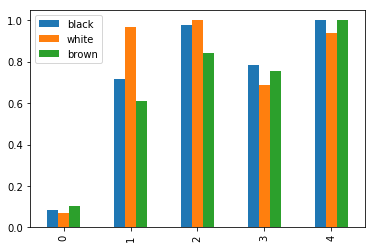

In [83]:
df_black_brown_white = pd.DataFrame({'black': color_black,
                                     'white': color_white,
                                     'brown': color_brown}, index=[0,1,2,3,4]).plot.bar()

## Assessing photo amount: no photo _vs_ 1 or more photos
It's clear from the graph below that a relatively large proportion of pets with no photos do not get adopted quickly. 

The underlying data shows the majority of pets have photos.

In [84]:
photo = df_train[df_train['PhotoAmt'] > 0].groupby(['AdoptionSpeed']).count()['PhotoAmt']
no_photo = df_train[df_train['PhotoAmt'] == 0].groupby(['AdoptionSpeed']).count()['PhotoAmt']

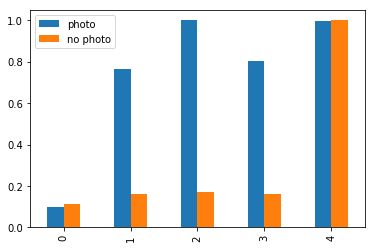

In [87]:
df_photos = pd.DataFrame({'photo': photo/max(photo),
                          'no photo': no_photo/max(no_photo)}, index=[0,1,2,3,4]).plot.bar()

# Submitting test data

In [246]:
X_test = apply_word_flags(df_test.copy(), keywords)
X_test = apply_color_flags(X_test, colors)
X_test = apply_breed_flags(X_test, breeds)
X_test = pd.get_dummies(X_test, columns=['Gender', 
                                         'Vaccinated', 'Dewormed', 'Sterilized', 
                                         'State'])
# X_test_petID = X_test['PetID']
X_test_all = X_test.drop(columns=['Name', 'RescuerID'])

In [265]:
# column in training but not test
print(X_train_all.keys() ^ X_test_all.keys())  # state 41415
X_test_all['State_41415'] = 0

Index([], dtype='object')


In [266]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_all, y_train_all)
prediction = rfc.predict(X_test_all)

In [268]:
submission = pd.DataFrame({'AdoptionSpeed': prediction}, index=X_test_all.index)
submission.to_csv("submission.csv", index=True, index_label='PetID', header=['AdoptionSpeed'])